Part 1 Bus delays

Load and prepare the data

In [30]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv('Exercise2BusData.csv')
df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [32]:
df = df.iloc[:1000]
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993908
Dwell_time               0.222777
Recurrent_delay          0.161830
Scheduled_travel_time    0.117362
Name: Arrival_delay, dtype: float64

Train/Test data split

In [33]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create a XBoost model

In [36]:
import xgboost as xgb

In [37]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV # <--- Note: Switched to RandomizedSearchCV
import numpy as np # Often used for defining parameter ranges

# 1. Define a more reasonable and broader parameter distribution for XGBoost
#    For continuous values, we can define a distribution instead of a fixed list
params = {
    'learning_rate':    [0.05, 0.1, 0.2, 0.3],         # Try a few reasonable learning rates
    'n_estimators':     [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], # Try 10 different values between 200 and 2000
    'max_depth':        [3, 5, 7, 10],            # More reasonable tree depths
    'min_child_weight': [1, 3, 5],               # Controls overfitting
    'gamma':            [0.0, 0.1, 0.2, 0.3],     # Controls overfitting
    'subsample':        [0.4, 0.6, 0.8, 1.0],     # Corrected row sampling rates
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0]      # Corrected column sampling rates (must be between 0-1)
}

# 2. Initialize the XGBoost model with a more robust base configuration
#    The objective function 'reg:squarederror' is fixed as this is a regression problem
xgb = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=-1,              # Use all available CPU cores
    random_state=42
)

# 3. Set up K-Fold Cross-Validation
folds = 5
skf = KFold(n_splits=folds, shuffle=True, random_state=1001)

# 4. Configure and run the Randomized Search (RandomizedSearchCV)
#    n_iter=100 means 100 random combinations will be tested from the large parameter space
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params, # Note the parameter name is param_distributions for RandomizedSearchCV
    n_iter=100,                 # Number of iterations for the random search
    scoring='neg_mean_squared_error',
    n_jobs=4,                   # Use 4 parallel jobs for the search
    cv=skf,
    verbose=2,                  # Print the progress of the search
    random_state=42
)

# Start the time-consuming model fitting and search process
random_search.fit(X_train_scaled, y_train)

# Get and print the best parameters
best_params = random_search.best_params_
print("Best Parameters found by Randomized Search:")
print(best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1800, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.

In [ ]:
# Step 1: Import all necessary libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# Step 2: Define model parameters and create the model
best_params_new = {
    'subsample': 0.4,
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.1,
    'gamma': 0.2,
    'colsample_bytree': 1.0
}

final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params_new,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10
)

# Step 3: Train the model
eval_set = [(X_test_scaled, y_test)]
print("Starting training with Early Stopping...")
final_xgb_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=eval_set,
    verbose=False
)
print(f"Training finished! Best iteration: {final_xgb_model.best_iteration}")

# Step 4: Use the trained model to make predictions ---
# This step creates the y_pred variable needed for the evaluation code
print("\nStarting prediction on the test set...")
y_pred = final_xgb_model.predict(X_test_scaled)
print("Prediction finished.")


Starting training with Early Stopping...
Training finished! Best iteration: 63

Starting prediction on the test set...
Prediction finished.


Model Evaluation

In [38]:

# Evaluate model performance (Numerical Metrics)
print("\n--- Numerical Evaluation Metrics ---")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print("-" * 25)




--- Numerical Evaluation Metrics ---
Mean Absolute Error (MAE): 10.3856
Mean Squared Error (MSE): 202.5413
Root Mean Squared Error (RMSE): 14.2317
R-squared: 0.9919
-------------------------


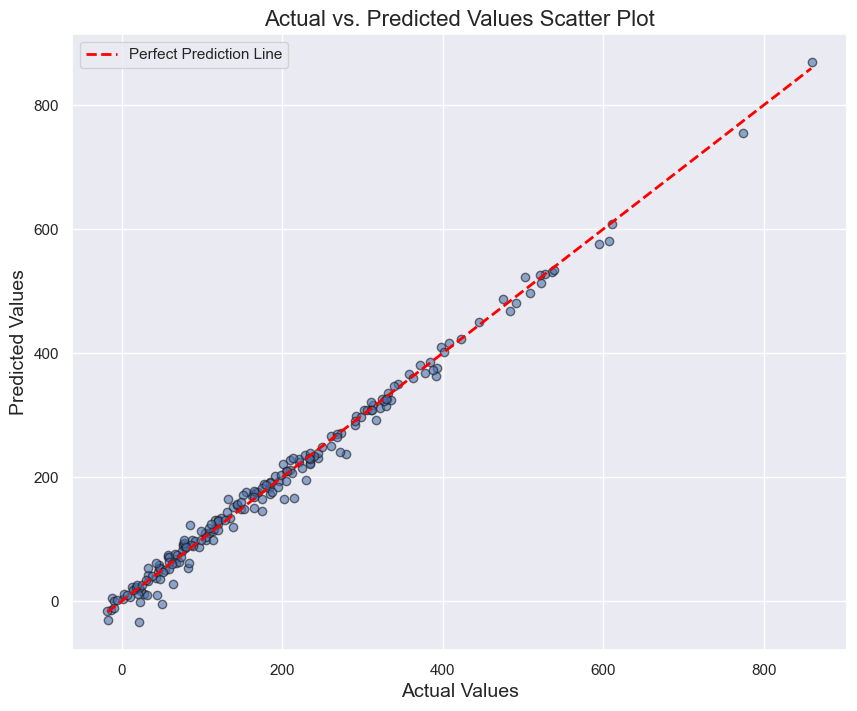

In [39]:
# Evaluate model performance (Visualization)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Actual vs. Predicted Values Scatter Plot", fontsize=16)
perfect_line = np.arange(min(y_test), max(y_test))
plt.plot(perfect_line, perfect_line, linestyle='--', color='red', lw=2, label='Perfect Prediction Line')
plt.legend()
plt.grid(True)
plt.show()

Part 2: Bike Demands

Download and prepare the data

In [40]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)

#df = pd.read_csv(r"D:\program\AH2179\Lab1\Dataset\Exercise2BikeSharing.csv")

df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1) # Drop unnecessary columns

#corr_matrix = df.corr()
#corr_matrix['Arrival_delay'].sort_values(ascending=False)

#drop arrival delay column
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

# df = pd.read_csv('Exercise2BusData.csv')
# df.head(10)

Train/Test data split

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Step 1: Import all necessary libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# Step 2: Define model parameters and create the model
best_params_new = {
    'subsample': 0.4,
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.1,
    'gamma': 0.2,
    'colsample_bytree': 1.0
}

final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params_new,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10
)

# Step 3: Train the model
eval_set = [(X_test_scaled, y_test)]
print("Starting training with Early Stopping...")
final_xgb_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=eval_set,
    verbose=False
)
print(f"Training finished! Best iteration: {final_xgb_model.best_iteration}")

# Step 4: Use the trained model to make predictions ---
# This step creates the y_pred variable needed for the evaluation code
print("\nStarting prediction on the test set...")
y_pred = final_xgb_model.predict(X_test_scaled)
print("Prediction finished.")

Starting training with Early Stopping...
Training finished! Best iteration: 69

Starting prediction on the test set...
Prediction finished.


Model Evaluation

In [ ]:
# Evaluate model performance (Numerical Metrics)
print("\n--- Numerical Evaluation Metrics ---")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print("-" * 25)




--- Numerical Evaluation Metrics ---
Mean Absolute Error (MAE): 10.6084
Mean Squared Error (MSE): 217.4010
Root Mean Squared Error (RMSE): 14.7445
R-squared: 0.9927
-------------------------


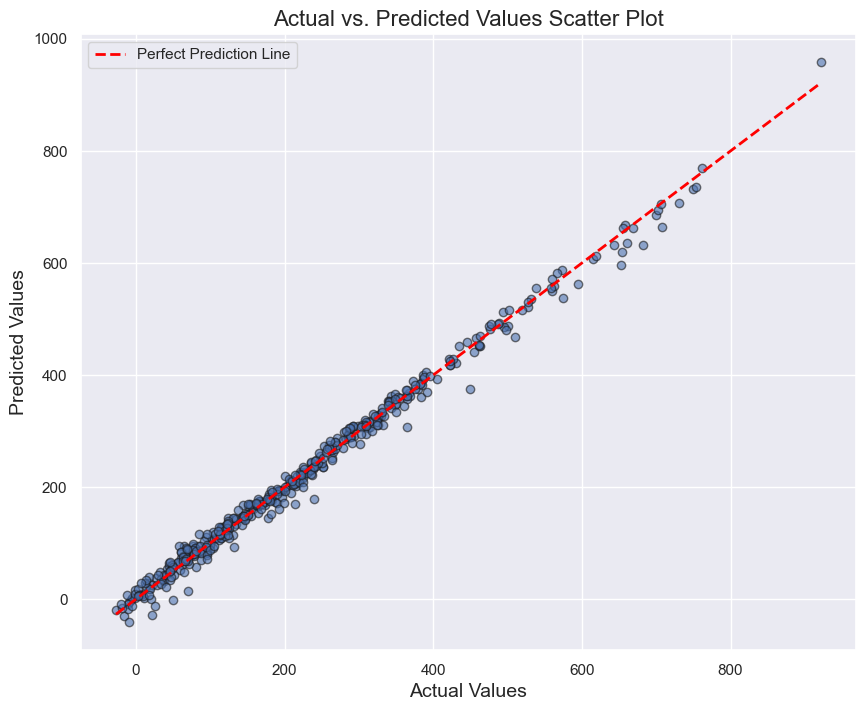

In [45]:
# Evaluate model performance (Visualization)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Actual vs. Predicted Values Scatter Plot", fontsize=16)
perfect_line = np.arange(min(y_test), max(y_test))
plt.plot(perfect_line, perfect_line, linestyle='--', color='red', lw=2, label='Perfect Prediction Line')
plt.legend()
plt.grid(True)
plt.show()